# PyTorch refresher

## 1. Tabular Classification

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader,Dataset
from torchsummary import summary
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
#Loading and cleaning dataset
df1 = pd.read_csv("rice-type-classification/riceClassification.csv")
df1.dropna(inplace=True)
df1.drop(["id"],axis=1,inplace=True)
print("prediction possibilites",df1["Class"].unique())
df1.head()

prediction possibilites [1 0]


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [3]:
# Data preprocessing
df1_copy = df1.copy() # hold a copy

# Normalize all values
for col in df1.columns:
    df1[col] = df1[col]/df1[col].abs().max()
df1.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [4]:
X = np.array(df1.iloc[:,:-1]) # Get the inputs, all rows and all columns except last column (output)
Y = np.array(df1.iloc[:, -1]) # Get the ouputs, all rows and last column only (output column)

X_train, X_test = train_test_split(X,test_size=0.30,random_state=42)
Y_train, Y_test = train_test_split(Y,test_size=0.30,random_state=42)

X_val, X_test = train_test_split(X_test,test_size=0.5,random_state=56)
Y_val, Y_test = train_test_split(Y_test,test_size=0.5,random_state=56)


print("Train size:",X_train.shape)
print("Test size:",X_test.shape)
print("validation size:",X_val.shape)

Train size: (12729, 10)
Test size: (2728, 10)
validation size: (2728, 10)


In [5]:
# Create a tensor struct
class dataset(Dataset):
    def __init__(self,X,Y):
        self.X = torch.tensor(X,dtype = torch.float32,device=device)
        self.Y = torch.tensor(Y,dtype = torch.float32,device=device)
    def __getitem__(self,idx):
        return self.X[idx],self.Y[idx]
    def __len__(self): #name needs to be __len__
        return len(self.X)
    
training_data = dataset(X_train,Y_train)
validation_data = dataset(X_val,Y_val)
testing_data = dataset(X_test,Y_test)

In [6]:
# Hyperparameters
EPOCH = 10
BATCH_SIZE = 32
LR = 1e-3
Hidden_neurons = 20

In [7]:
# Dataloaders
train_dataloader = DataLoader(training_data,shuffle=True,batch_size=BATCH_SIZE)
validation_dataloader = DataLoader(validation_data,shuffle=True,batch_size=BATCH_SIZE)
test_dataloader = DataLoader(testing_data,shuffle=True,batch_size=BATCH_SIZE)

In [8]:
# Defining the model and a forward pass function
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.input_layer = nn.Linear(X.shape[1],Hidden_neurons)
        self.hidden = nn.Linear(Hidden_neurons,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        x = self.input_layer(x)
        x = self.hidden(x)
        x = self.sigmoid(x)
        return x

In [9]:
# Model Creation
model = Model().to(device=device)
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]             220
            Linear-2                    [-1, 1]              21
           Sigmoid-3                    [-1, 1]               0
Total params: 241
Trainable params: 241
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [10]:
# Loss functions and optimizers
criterion = nn.BCELoss() # Binary cross entropy loss because prediction is binary. 
optimizer = Adam(model.parameters(),lr = LR)

In [11]:
# Training Loop

# Metadata for plotting 
train_loss,val_loss,train_acc,val_acc = [],[],[],[]

while(EPOCH):
    print(EPOCH)
    EPOCH -= 1
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0
    #training
    for data in train_dataloader:
        input, labels = data
        prediction = model(input).squeeze(1)
        batch_loss = criterion(prediction,labels)
        total_loss_train = batch_loss.item()
        acc = (prediction.round() == labels).sum().item()
        total_acc_train += acc
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    #validation
    with torch.no_grad():
        for data in validation_dataloader:
            input, labels = data
            prediction = model(input).squeeze(1)
            batch_loss = criterion(prediction,labels)
            total_loss_val = batch_loss.item()
            acc = (prediction.round() == labels).sum().item()
            total_acc_val += acc
    train_loss.append(round(total_loss_train/1000,4))
    val_loss.append(round(total_loss_val/1000,4))
    train_acc.append(round(total_acc_train/(training_data.__len__())*100, 4))
    val_acc.append(round(total_acc_val/(validation_data.__len__())*100, 4))

    print(f'''Epoch no. {EPOCH+1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
    print("="*50)

10
Epoch no. 10 Train Loss: 0.0003 Train Accuracy: 85.9219 Validation Loss: 0.0003 Validation Accuracy: 97.2507
9
Epoch no. 9 Train Loss: 0.0001 Train Accuracy: 98.1303 Validation Loss: 0.0001 Validation Accuracy: 98.0572
8
Epoch no. 8 Train Loss: 0.0000 Train Accuracy: 98.3502 Validation Loss: 0.0000 Validation Accuracy: 98.5704
7
Epoch no. 7 Train Loss: 0.0000 Train Accuracy: 98.5073 Validation Loss: 0.0001 Validation Accuracy: 98.4971
6
Epoch no. 6 Train Loss: 0.0000 Train Accuracy: 98.5859 Validation Loss: 0.0000 Validation Accuracy: 98.6804
5
Epoch no. 5 Train Loss: 0.0000 Train Accuracy: 98.5938 Validation Loss: 0.0000 Validation Accuracy: 98.6437
4
Epoch no. 4 Train Loss: 0.0000 Train Accuracy: 98.5309 Validation Loss: 0.0001 Validation Accuracy: 98.6437
3
Epoch no. 3 Train Loss: 0.0000 Train Accuracy: 98.5702 Validation Loss: 0.0000 Validation Accuracy: 98.7170
2
Epoch no. 2 Train Loss: 0.0000 Train Accuracy: 98.5623 Validation Loss: 0.0000 Validation Accuracy: 98.6437
1
Epoch 

In [12]:
#testing
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for data in test_dataloader:
        inputs,labels = data
        prediction = model(inputs).squeeze(1)
        batch_loss = criterion(prediction,labels)
        total_loss_test += batch_loss.item()
        acc = (prediction.round() == labels).sum().item()
        total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")

Accuracy Score is: 98.9%


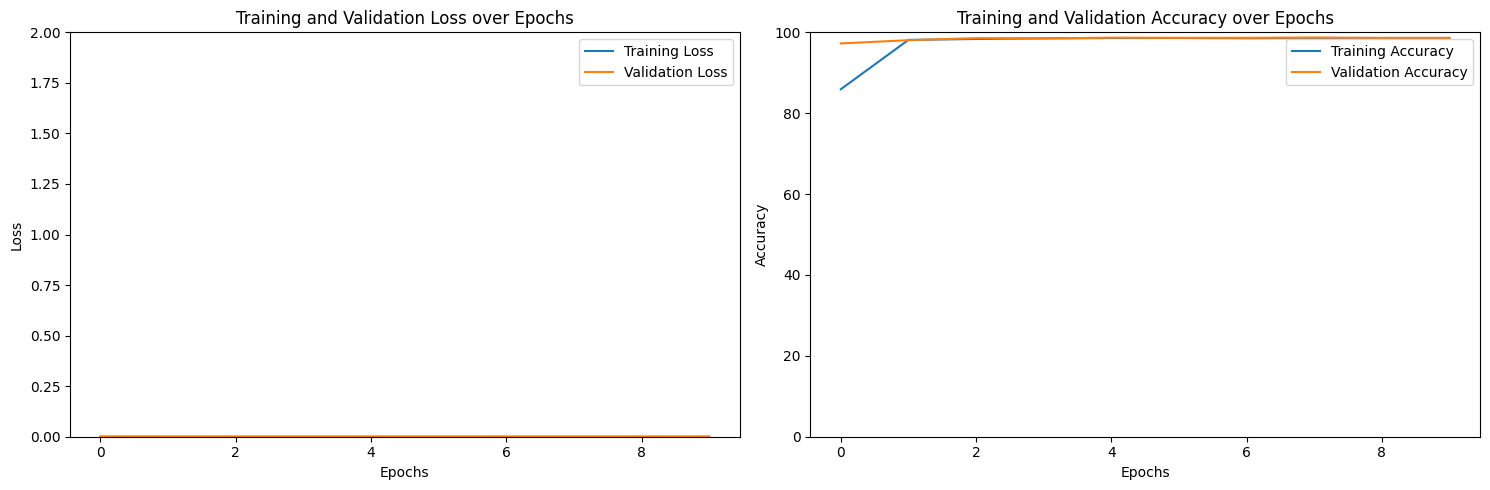

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(train_loss, label='Training Loss')
axs[0].plot(val_loss, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(train_acc, label='Training Accuracy')
axs[1].plot(val_acc, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

## 2. simple Image classification

In [14]:
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import transforms
from PIL import Image
import os

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cpu


In [15]:
image_paths = []
labels = []

for i in os.listdir('animal-faces/afhq'):
    for label in os.listdir(f'animal-faces/afhq/{i}'):
        for image in os.listdir(f'animal-faces/afhq/{i}/{label}'):
            labels.append(label)
            image_paths.append(f"animal-faces/afhq/{i}/{label}/{image}")

df2 = pd.DataFrame(zip(image_paths,labels),columns=['images','labels'])
df2.head()

,images,labels
0,animal-faces/afhq/train/cat/flickr_cat_000002.jpg,cat
1,animal-faces/afhq/train/cat/flickr_cat_000003.jpg,cat
2,animal-faces/afhq/train/cat/flickr_cat_000004.jpg,cat
3,animal-faces/afhq/train/cat/flickr_cat_000005.jpg,cat
4,animal-faces/afhq/train/cat/flickr_cat_000006.jpg,cat


In [16]:
train_df=df2.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test_df=df2.drop(train_df.index) # Create testing by removing the 70% of the train data which will result in 30%

val_df=test_df.sample(frac=0.5,random_state=7) # Create validation of 50% of the testing data
test_df=test_df.drop(val_df.index) # Create testing by removing the 50% of the validation data which will result in 50%

In [17]:
label_encoder = LabelEncoder()
label_encoder.fit(df2['labels'])

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])


In [27]:
# custom dataset class

class CustomImageDataset(Dataset):
    def __init__(self,dataframe,transform=None):
        self.dataframe = dataframe
        self.transform = transform if transform is not None else transforms.ToTensor()
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['images']
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image) 
        return image, label

In [36]:
train_dataset = CustomImageDataset(train_df,transform=transform)
validation_dataset = CustomImageDataset(val_df,transform=transform)
test_dataset = CustomImageDataset(test_df,transform=transform)

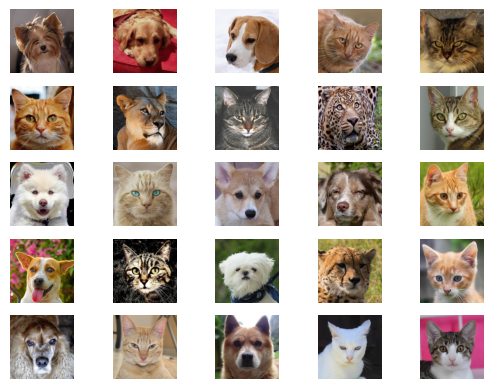

In [37]:
f, ax = plt.subplots(5,5)
for row in range(5):
    for col in range(5):
        image = Image.open(df2.sample(n=1)['images'].iloc[0]).convert('RGB')
        ax[row,col].imshow(image)
        ax[row,col].axis('off')
plt.show()

In [38]:
# Hyper parameters
LR = 1e-4
BATCH_SIZE = 32
EPOCHS = 10

In [39]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [40]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.pooling = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128*16*16,128)
        self.output = nn.Linear(128,len(df2['labels'].unique()))

    def forward(self,x):
        x = self.conv1(x)
        x = self.pooling(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.pooling(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.pooling(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)
        return x

model = Net().to(device)


In [41]:
summary(model,input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [42]:
# Loss functions
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),LR)

In [47]:
# Training Loop

train_acc,val_acc,train_loss,val_loss = [],[],[],[]

for epoch in range(EPOCHS):
    tot_tr_acc,tot_val_acc,tot_tr_loss,tot_val_loss = 0,0,0,0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        tr_loss = criterion(outputs,labels)
        tot_tr_loss += tr_loss.item()
        tr_loss.backward()
        tr_acc = (torch.argmax(outputs,axis = 1)==labels).sum().item()
        tot_tr_acc += tr_acc
        optimizer.step()
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            outputs = model(inputs)
            val_loss_ = criterion(outputs,labels)
            tot_val_loss += val_loss_.item()
            val_acc_ = (torch.argmax(outputs,axis = 1)==labels).sum().item()
            tot_val_acc += val_acc_

    train_loss.append(round(tot_tr_loss/1000,4))
    val_loss.append(round(tot_val_loss/1000,4))
    train_acc.append(round(tot_tr_acc/(train_dataset.__len__())*100, 4))
    val_acc.append(round(tot_val_acc/(validation_dataset.__len__())*100, 4))
    print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(tot_tr_loss/1000, 4)} Train Accuracy: {round(tot_tr_acc/len(train_dataset) * 100, 4)}
            Validation Loss: {round(tot_val_loss/1000, 4)} Validation Accuracy: {round(tot_val_acc/len(validation_dataset) * 100, 4)}''')
    print("="*50)

Epoch 1/10, Train Loss: 0.0368 Train Accuracy: 96.4751
            Validation Loss: 0.0111 Validation Accuracy: 95.0413
Epoch 2/10, Train Loss: 0.0287 Train Accuracy: 97.1925
            Validation Loss: 0.0129 Validation Accuracy: 93.9669
Epoch 3/10, Train Loss: 0.0221 Train Accuracy: 97.7681
            Validation Loss: 0.0099 Validation Accuracy: 95.5785
Epoch 4/10, Train Loss: 0.0173 Train Accuracy: 98.3881
            Validation Loss: 0.0102 Validation Accuracy: 95.6198
Epoch 5/10, Train Loss: 0.0136 Train Accuracy: 98.7335
            Validation Loss: 0.013 Validation Accuracy: 94.7521
Epoch 6/10, Train Loss: 0.0124 Train Accuracy: 98.8664
            Validation Loss: 0.0101 Validation Accuracy: 95.3719
Epoch 7/10, Train Loss: 0.007 Train Accuracy: 99.4863
            Validation Loss: 0.0107 Validation Accuracy: 95.6612
Epoch 8/10, Train Loss: 0.0069 Train Accuracy: 99.4243
            Validation Loss: 0.0111 Validation Accuracy: 95.3719
Epoch 9/10, Train Loss: 0.0051 Train Accur

In [52]:
with torch.no_grad():
    tot_test_loss,tot_test_acc = 0,0
    for inputs, labels in test_dataloader:
        preds = model(inputs)
        test_acc = (torch.argmax(preds,axis = 1)==labels).sum().item()
        tot_test_acc += test_acc
        test_loss = criterion(preds,labels)
        tot_test_loss += test_loss.item()
print(f"Accuracy Score is: {round((tot_test_acc/test_dataset.__len__()) * 100, 4)} and Loss is {round(tot_test_loss/1000, 4)}")

Accuracy Score is: 96.1141 and Loss is 0.0107


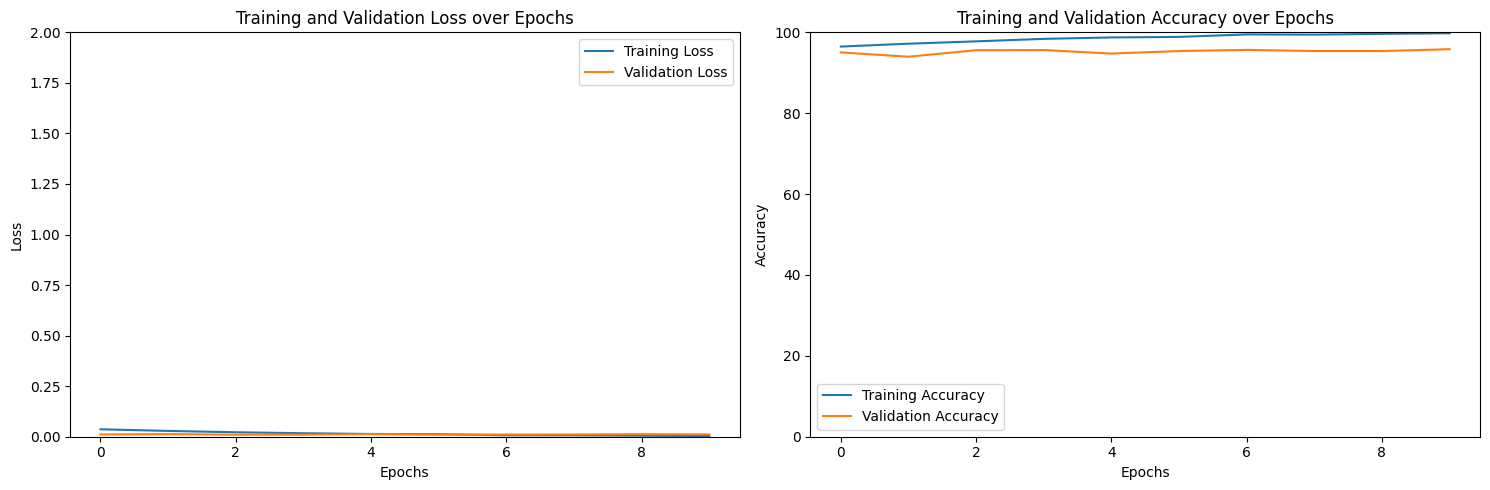

In [53]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(train_loss, label='Training Loss')
axs[0].plot(val_loss, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(train_acc, label='Training Accuracy')
axs[1].plot(val_acc, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

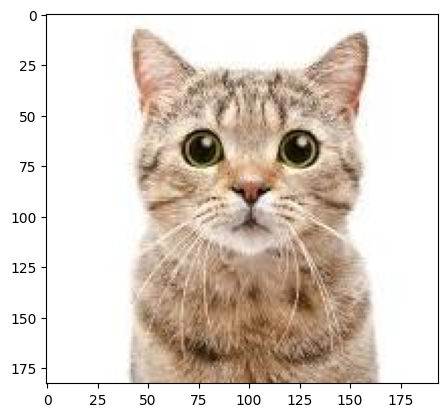


Prediction: 



array(['cat'], dtype=object)

In [54]:
# Inference
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).to(device)

    output = model(image.unsqueeze(0))
    output = torch.argmax(output,axis = 1).item()
    return label_encoder.inverse_transform([output])

## Visualize the image
image = Image.open("cat_photo.jpg")
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("cat_photo.jpg")
